In [1]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

2023-05-12 08:31:58.131097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 08:31:58.131121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [23]:
def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
   
    M1_dense_2 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    return model

In [24]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [25]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [26]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [27]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [28]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [29]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [30]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [31]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [32]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [33]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D


def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)] #Dense(4 * ff_dim, activation="relu")
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# transformer based embedding model
def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

Training CNN model...
Epoch 1/50
7/7 [==============================] - 1s 94ms/step - loss: 0.6926 - accuracy: 0.5014 - auc_roc: 0.5102 - val_loss: 0.6910 - val_accuracy: 0.5022 - val_auc_roc: 0.6085
Epoch 2/50
7/7 [==============================] - 0s 63ms/step - loss: 0.6853 - accuracy: 0.5548 - auc_roc: 0.6018 - val_loss: 0.6844 - val_accuracy: 0.6345 - val_auc_roc: 0.7148
Epoch 3/50
7/7 [==============================] - 0s 70ms/step - loss: 0.6816 - accuracy: 0.5683 - auc_roc: 0.5952 - val_loss: 0.6739 - val_accuracy: 0.6726 - val_auc_roc: 0.7698
Epoch 4/50
7/7 [==============================] - 0s 64ms/step - loss: 0.6654 - accuracy: 0.6239 - auc_roc: 0.6734 - val_loss: 0.6600 - val_accuracy: 0.6973 - val_auc_roc: 0.7895
Epoch 5/50
7/7 [==============================] - 0s 64ms/step - loss: 0.6424 - accuracy: 0.6667 - auc_roc: 0.7311 - val_loss: 0.6402 - val_accuracy: 0.7197 - val_auc_roc: 0.8048
Epoch 6/50
7/7 [==============================] - 0s 64ms/step - loss: 0.6222 - acc

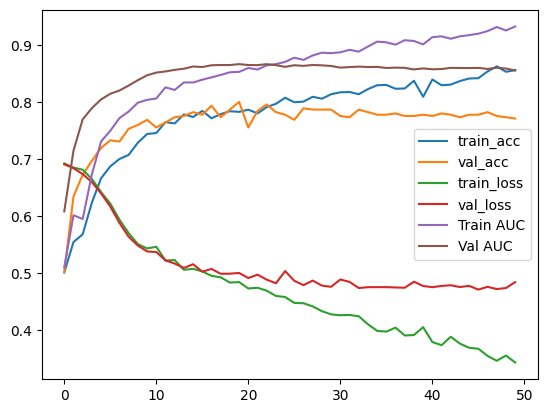


 Acc: 0.7713004484304933, MCC: 0.5493179214878917, SN:0.8468468468468469, SP:0.6964285714285714, 
 CM:[[156  68]
 [ 34 188]]


In [36]:
# Training DE-Phosphorylation

n_epo_cnn = 50

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

checkpointer = ModelCheckpoint(filepath="../models/no_pretrain_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("Training CNN model...")

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/no_pretrain_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [37]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/no_pretrain_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8004484304932735, MCC: 0.6009998260182645, SN:0.7882882882882883, SP:0.8125, 
 CM:[[182  42]
 [ 47 175]]


Training Embedding model...
Epoch 1/10
7/7 [==============================] - 1s 40ms/step - loss: 0.6188 - accuracy: 0.6582 - auc_roc: 0.7540 - val_loss: 0.5070 - val_accuracy: 0.7578 - val_auc_roc: 0.8282
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5438 - accuracy: 0.7499 - auc_roc: 0.8077 - val_loss: 0.4889 - val_accuracy: 0.7803 - val_auc_roc: 0.8466
Epoch 3/10
7/7 [==============================] - 0s 12ms/step - loss: 0.5017 - accuracy: 0.7594 - auc_roc: 0.8381 - val_loss: 0.4843 - val_accuracy: 0.7892 - val_auc_roc: 0.8553
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4767 - accuracy: 0.7802 - auc_roc: 0.8564 - val_loss: 0.4626 - val_accuracy: 0.7960 - val_auc_roc: 0.8643
Epoch 5/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4581 - accuracy: 0.7892 - auc_roc: 0.8669 - val_loss: 0.4602 - val_accuracy: 0.8094 - val_auc_roc: 0.8680
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4416

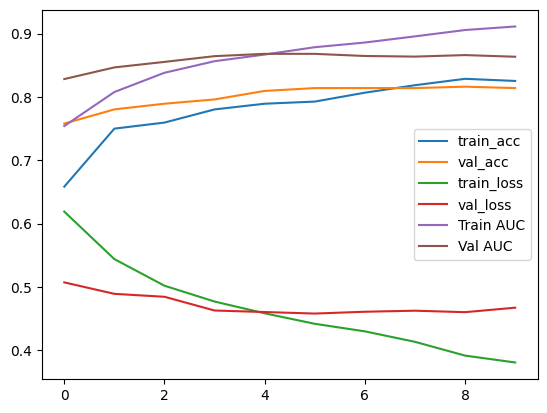


 Acc: 0.8139013452914798, MCC: 0.6291086398999636, SN:0.7792792792792793, SP:0.8482142857142857, 
 CM:[[190  34]
 [ 49 173]]


 Acc: 0.8161434977578476, MCC: 0.6331086333197146, SN:0.7882882882882883, SP:0.84375, 
 CM:[[189  35]
 [ 47 175]]


In [38]:
########### Model B

n_epo_embedding = 10
print("Training Embedding model...")

model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

checkpointer = ModelCheckpoint(filepath="../models/no_pretrain_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embedding, verbose=1, 
                        callbacks=[checkpointer], 
                        validation_data=(X_test_full_ST_embedding, test_ST_labels))

#model_B.save_weights('../models/no_pretrain_model_B.h5')

y_pred = model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(history_B)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/no_pretrain_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training Transformer model...
Epoch 1/40
7/7 [==============================] - 3s 298ms/step - loss: 0.7355 - accuracy: 0.5059 - auc_roc: 0.6110 - val_loss: 0.6731 - val_accuracy: 0.5964 - val_auc_roc: 0.6669
Epoch 2/40
7/7 [==============================] - 2s 223ms/step - loss: 0.6740 - accuracy: 0.5739 - auc_roc: 0.6087 - val_loss: 0.6459 - val_accuracy: 0.6637 - val_auc_roc: 0.7034
Epoch 3/40
7/7 [==============================] - 1s 209ms/step - loss: 0.6589 - accuracy: 0.6211 - auc_roc: 0.6560 - val_loss: 0.6164 - val_accuracy: 0.6592 - val_auc_roc: 0.7239
Epoch 4/40
7/7 [==============================] - 2s 226ms/step - loss: 0.6381 - accuracy: 0.6453 - auc_roc: 0.6977 - val_loss: 0.6027 - val_accuracy: 0.6749 - val_auc_roc: 0.7358
Epoch 5/40
7/7 [==============================] - 2s 227ms/step - loss: 0.6148 - accuracy: 0.6599 - auc_roc: 0.7208 - val_loss: 0.5968 - val_accuracy: 0.6682 - val_auc_roc: 0.7363
Epoch 6/40
7/7 [==============================] - 1s 213ms/step - loss

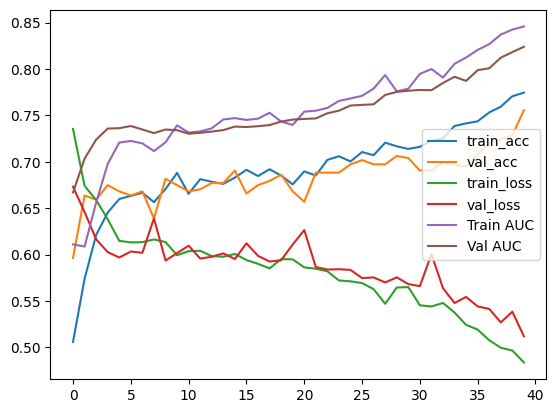


 Acc: 0.7556053811659192, MCC: 0.5179552055347604, SN:0.8333333333333334, SP:0.6785714285714286, 
 CM:[[152  72]
 [ 37 185]]


 Acc: 0.7556053811659192, MCC: 0.5179552055347604, SN:0.8333333333333334, SP:0.6785714285714286, 
 CM:[[152  72]
 [ 37 185]]


In [39]:
############# Training Transformer


model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

print("Training Transformer model...")

n_epo_transformer = 40

checkpointer = ModelCheckpoint(filepath="../models/no_pretrain_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_C.save_weights('../models/no_pretrain_model_C.h5')

y_pred = model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/no_pretrain_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [93]:
# load models from file
def load_A_models():
    model_A = CNN_model()
    model_A.load_weights('../models/no_pretrain_model_A.h5')
    return model_A


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/no_pretrain_model_B.h5')
    return model

def load_C_models():
    model = transformer_model()
    model.load_weights('../models/no_pretrain_model_C.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in members]
    #ensemble_outputs = [model.output for model in members]
    ensemble_outputs = [model.get_layer(index = len(model.layers) - 2).output for model in members]
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    hidden = Dropout(0.4, name = 'dp_2')(merge)
    hidden = Dense(128, activation='relu', name = 'ds_1')(hidden)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(32, activation='relu', name = 'ds_2')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    return model

# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)

n_epo_stacked = 20

checkpointer = ModelCheckpoint(filepath="../models/no_pretrain_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)
st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, callbacks = [checkpointer],
                               verbose=1, validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

Loaded 3 models
Epoch 1/20
56/56 [==============================] - 2s 23ms/step - loss: 0.5098 - accuracy: 0.7437 - auc_roc: 0.8357 - val_loss: 0.4254 - val_accuracy: 0.8139 - val_auc_roc: 0.8872
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 0.4062 - accuracy: 0.8269 - auc_roc: 0.8978 - val_loss: 0.4242 - val_accuracy: 0.8251 - val_auc_roc: 0.8876
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 0.4039 - accuracy: 0.8235 - auc_roc: 0.8985 - val_loss: 0.4281 - val_accuracy: 0.8296 - val_auc_roc: 0.8857
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 0.3958 - accuracy: 0.8370 - auc_roc: 0.9021 - val_loss: 0.4288 - val_accuracy: 0.8229 - val_auc_roc: 0.8841
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3877 - accuracy: 0.8392 - auc_roc: 0.9072 - val_loss: 0.4278 - val_accuracy: 0.8341 - val_auc_roc: 0.8854
Epoch 6/20
56/56 [==============================] - 1s 18ms/step - loss: 0.3804

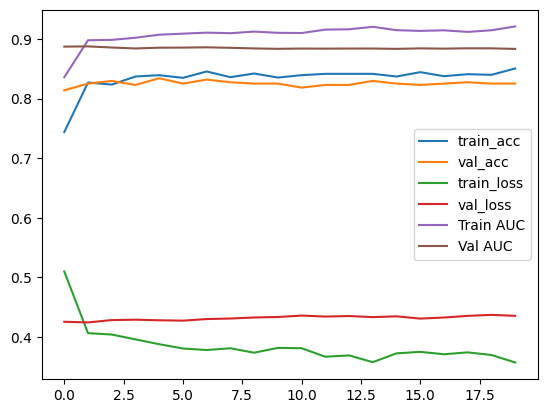


 Acc: 0.8251121076233184, MCC: 0.6502171814671814, SN:0.8243243243243243, SP:0.8258928571428571, 
 CM:[[185  39]
 [ 39 183]]


 Acc: 0.8340807174887892, MCC: 0.6682889571941063, SN:0.8423423423423423, SP:0.8258928571428571, 
 CM:[[185  39]
 [ 35 187]]


In [94]:
# Predict
y_pred = stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(st_history)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/no_pretrain_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

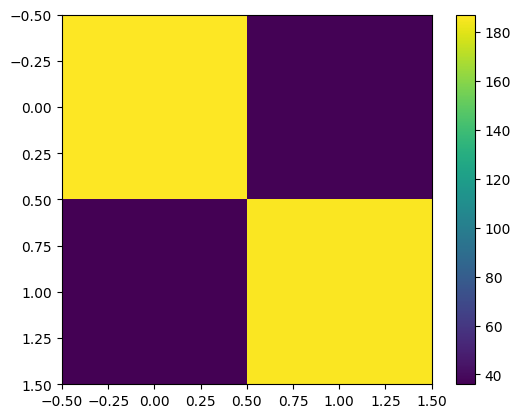

In [79]:
plt.imshow(cm)
plt.colorbar()
plt.show()

In [99]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py


#print(re_stacked_model.summary())

#print(len(re_stacked_model.layers))

# create truncated model
#truncated_ANN_model = Model(inputs=re_stacked_model.input,
#                                 outputs=re_stacked_model.get_layer(index=21).output)

#hidden_features = truncated_ANN_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN])

loaded_model_C.summary()
print("Number of layers: ", len(loaded_model_C.layers))
truncated_CNN_model = Model(inputs=loaded_model_C.input,
                                 outputs=loaded_model_C.get_layer(index=len(loaded_model_C.layers) - 3).output) #20
hidden_features = truncated_CNN_model.predict([X_test_CNN])

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = test_ST_labels

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 128)          6912      
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_3 (Transf  ((None, 33, 128),        165504    
 ormerBlock)                  (None, 2, 33, 33))                 
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_34 (Dropout)        (None, 128)               0   

/home/anupkumar/anaconda3/envs/succsite/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


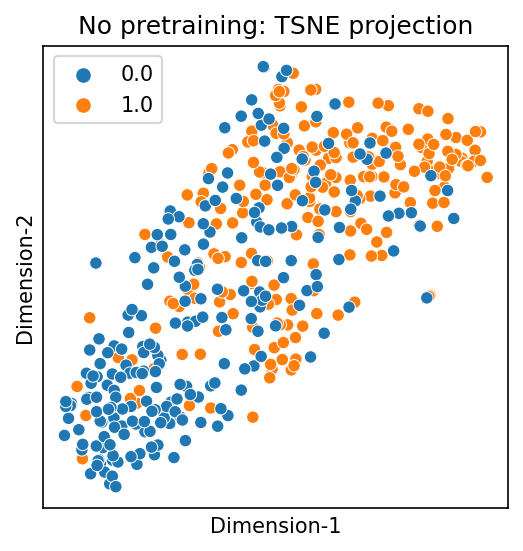

In [100]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20) #learning_rate = 10, perplexity=30

tsne_features = m.fit_transform(hidden_features)

df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("No pretraining: TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_stacked_no_pretraining.png"
plt.savefig(filename,dpi=150,bbox_inches='tight')
plt.show()

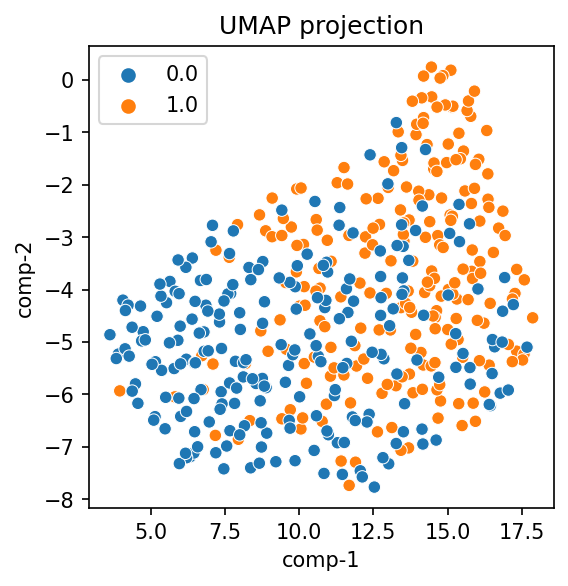

In [101]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 100
min_dist= 0.9

n_components=2

metric='euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["comp-1"] = proj_2d[:,0]
df_umap["comp-2"] = proj_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=test_ST_labels, data=df_umap).set(title="UMAP projection") #palette=sns.color_palette("hls", n_colors)
filename = "UMAP_stacked_no_pretrain.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')